# One-shot face recognition tutorial

This tutorial based on this [video](https://www.youtube.com/watch?v=LKispFFQ5GU) will use tensorflow v2 to create a face recognition model based on the one-shot architecture. <br/>

The steps are:

## Workspace setup

Let's import all the shared libraries that notebook uses section-wide

In [1]:
from os import path
from typing import Final, Any

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

Let's create a workspace with all the necessary folders in it

In [56]:
import os

WORKSPACE_DIR_PATH: Final[str] = 'tutorial_workspace'
DOWNLOADS_PATH: Final[str] = path.join(WORKSPACE_DIR_PATH, 'downloads')
ANCHORS_PATH: Final[str] = path.join(WORKSPACE_DIR_PATH, 'anchors')
POSITIVES_PATH: Final[str] = path.join(WORKSPACE_DIR_PATH, 'positives')
NEGATIVES_PATH: Final[str] = path.join(WORKSPACE_DIR_PATH, 'negatives')
OUTPUTS_PATH: Final[str] = path.join(WORKSPACE_DIR_PATH, 'outputs')

os.makedirs(DOWNLOADS_PATH, exist_ok=True)
os.makedirs(ANCHORS_PATH, exist_ok=True)
os.makedirs(POSITIVES_PATH, exist_ok=True)
os.makedirs(NEGATIVES_PATH, exist_ok=True)
os.makedirs(OUTPUTS_PATH, exist_ok=True)

print('All necessary folders created')

All necessary folders created


## Data fetching

To train a model a dataset is necessary. <br/>
For that we will use the `LFW` dataset

### Fetch dataset

The dataset we will use named `LFW` and you can find it either in this [link](http://vis-www.cs.umass.edu/lfw/#download) or at the code below

In [3]:
import shutil
import requests

TAR_URL: Final[str] = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
FILE_NAME: Final[str] = 'lfw.tgz'
file_path: str = path.join(DOWNLOADS_PATH, FILE_NAME)

if not path.exists(file_path):
    # Make an HTTP request within a context manager
    with requests.get(TAR_URL, stream=True) as r:
        
        # Check header to get content length, in bytes
        total_length = int(r.headers.get("Content-Length"))
        
        # Implement progress bar via tqdm
        with tqdm.wrapattr(r.raw, "read", total=total_length, desc="lfw.tar compressed dataset") as raw:
        
            # Save the output to a file
            with open(file_path, 'wb')as output:
                shutil.copyfileobj(raw, output)
else:
    print('Dataset already downloaded')

Dataset already downloaded


### Extract the dataset

As described above, the model needs a lot faces that not match to the anchors. <br/>
For that we will use the dataset we downloaded above.

So, we will extract the compressed files. and put them into the `NEGATIVES_PATH`.

In [6]:
import tarfile
from typing import IO, Iterable

file_path: str = path.join(DOWNLOADS_PATH, 'lfw.tgz')

with tarfile.open(file_path, 'r:gz') as compressed_file:
    # Filtering out all directories and non-jpg files
    all_members: Iterable[tarfile.TarInfo] = [m for m in compressed_file.getmembers() if '.jpg' in m.name or '.png' in m.name]
    
    for member in tqdm(iterable=all_members, total=len(all_members)):
        archive_filename: str = member.path.split('/')[-1]
        filename: str = path.join(NEGATIVES_PATH, archive_filename)
        
        buffer_reader: IO[bytes] = compressed_file.extractfile(member)
        with open(filename, 'wb') as file:
            file.write(buffer_reader.read())

100%|██████████| 13233/13233 [01:22<00:00, 159.45it/s]


### Collect positive and anchors data

Until now, we successfully loaded the `LFW` dataset into our workspace as negative shots (observations).

Now, let's dive into the positives.
So, we can get those observations in many ways. Like taking shots from the camera, use existing images. <br/>
Let's do both!

#### Taking shots from webcam

Before we take shots from the camera, we need to remember. The dataset has 250x250 pixels images. <br/>
For the simplicity of this project, we will preffer to use the exact same size with the new shots.

So remember, 250x250...

Don't forget to import necessary packages for that phase

In [3]:
import cv2
import uuid

In [4]:
# In case it not working properly, you can try with different index
cap = cv2.VideoCapture(0)
is_device_connected: bool = cap.isOpened()
print(f"The device is { 'connected' if is_device_connected else 'disconnected' }")
while is_device_connected:
    ret, frame = cap.read()

    # Cut a 250x250 pixels crop from the original feed
    start_x: int = 200
    start_y: int = 120
    height: int = start_y + 250
    width: int = start_x + 250
    frame = frame[start_x:width, start_y:height, :]

    # Collect anchor image
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Creating unique filename
        generated_name: str = f'{uuid.uuid1()}.jpg'
        img_name: str = path.join(ANCHORS_PATH, generated_name)
        cv2.imwrite(img_name, frame)

    # Collect positive image
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Creating unique filename
        generated_name: str = f'{uuid.uuid1()}.jpg'
        img_name: str = path.join(POSITIVES_PATH, generated_name)
        cv2.imwrite(img_name, frame)

    # Show image back to screen
    cv2.imshow('Image collection', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

The device is connected


In [ ]:
print('Frame shape:', frame.shape)
plt.title('Last frame detected')
plt.imshow(frame)

##### In case the code above not working

In case you don't know which `device id` to use in the opencv's video `device id`. <br />
Let's search for all the devices available to take images from

In [3]:
def list_ports():
    """
        Test the ports and returns a tuple with the available ports and the ones that are working.
    """
    non_working_ports = []
    dev_port = 0
    working_ports = []
    available_ports = []
    while len(non_working_ports) < 6: # if there are more than 5 non working ports stop the testing. 
        print(f'Testing index {dev_port}')
        camera = cv2.VideoCapture(dev_port)
        if not camera.isOpened():
            non_working_ports.append(dev_port)
            print("Port %s is not working." %dev_port)
        else:
            is_reading, img = camera.read()
            w = camera.get(3)
            h = camera.get(4)
            if is_reading:
                print("Port %s is working and reads images (%s x %s)" %(dev_port,h,w))
                working_ports.append(dev_port)
            else:
                print("Port %s for camera ( %s x %s) is present but does not reads." %(dev_port,h,w))
                available_ports.append(dev_port)
        dev_port +=1
    return available_ports,working_ports,non_working_ports

print(list_ports())

Testing index 0
Port 0 is working and reads images (480.0 x 640.0)
Testing index 1
Port 1 is not working.
Testing index 2
Port 2 is not working.
Testing index 3
Port 3 is not working.
Testing index 4
Port 4 is not working.
Testing index 5
Port 5 is not working.
Testing index 6
Port 6 is not working.
([], [0], [1, 2, 3, 4, 5, 6])


#### Load data from existing images

Alternitivly, you can load the positive and anchors images from existing images files. <br/>
Just copy your images positive images into `$POSITIVES_PATH`, and the anchors will be copied into `ANCHORS_PATH`.

Don't forget to make sure that the photos you are importing have to be at shape (resolution) of `250px*250px`

## Preprocess

All the data successfully collected. Let's start to prepare it to the training phase.

So, what we will do in this phase is:
* Create labeled dataset from the anchors, positives and negatives directories
* Split the dataset into training and validation sets

### Phase imports

In [3]:
from typing import Union
import tensorflow as tf
from tf_agents.typing.types import EagerTensor

2023-02-05 10:48:37.949114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 10:48:38.600541: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-05 10:48:38.890528: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-05 10:48:40.543388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### Data loading

Let's verify that all of the images we will going to use, having the same 'shape' (dimensions). <br/>
In case they are different, we will scale them to the apropriate dimensions.

In [4]:
DATASET_SIZE: Final[int] = 300

# Tensorflow will take all files matching to the pattern inside `list_files()`
anchor: tf.data.Dataset = tf.data.Dataset.list_files(f'{ANCHORS_PATH}/*.jpg').take(DATASET_SIZE)
positive: tf.data.Dataset = tf.data.Dataset.list_files(f'{POSITIVES_PATH}/*.jpg').take(DATASET_SIZE)
negative: tf.data.Dataset = tf.data.Dataset.list_files(f'{NEGATIVES_PATH}/*.jpg').take(DATASET_SIZE)

negative.as_numpy_iterator(), anchor.as_numpy_iterator(), positive.as_numpy_iterator()

2023-02-05 10:48:48.685399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:b3:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 10:48:48.823372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:b3:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 10:48:48.823798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:b3:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 10:48:48.829030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

(<tensorflow.python.data.ops.dataset_ops._NumpyIterator at 0x7fd4e0d66590>,
 <tensorflow.python.data.ops.dataset_ops._NumpyIterator at 0x7fd4e0ddcb50>)

Example: This how you can iterate over a tensorlow Dataset class (in this case we will run over the anchors)

In [5]:
anchor.as_numpy_iterator().next()

b'tutorial_workspace/anchors/2a4503b8-9cb7-11ed-baa1-b808cf4c516c.jpg'

### Scale and resize the images

In [6]:
def preprocess(file_path: str):
    # Read image bytes from file path
    byte_image = tf.io.read_file(file_path)
    
    # Loading the bytes as image
    image = tf.io.decode_jpeg(byte_image)

    # Resize the image to 100x100 pixels
    image: EagerTensor = tf.image.resize(image, (100, 100))
    
    # Devide each pixel between (0 and 1) instead of (0 and 255)
    image /= 255.0

    return image

Just to be sure, let's verify that the pre process have done successfully.

In [ ]:
# Duplicate one of the lists 
_dup_anchor = anchor.as_numpy_iterator()

# Running the preprocess on the current image
img = preprocess(_dup_anchor.next())

print('Minimum value in tensor (should be 0):', img.numpy().min())
print('Max value in tensor (should be 1):', img.numpy().max())
print('Image shape (should be (100, 100, 3)):', img.numpy().shape)
plt.imshow(img)

### Create the labeled dataset

To train the model, we will need to give it:
* Positive observations (which means anchor image, positive image and result of 1).
* Negative observations (which means anchor image, negative and result of 0).

For that we will create two datasets, one for positive and one for negative. And concatenate them together.

In [8]:
positive_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))) # Create a vector with shape of positive images
negative_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))) # Create a vector with shape of negative images

# Telling the data loader to load each of those images with the proper label simultaneously 
positive_dataset = tf.data.Dataset.zip((anchor, positive, positive_labels))
negative_dataset = tf.data.Dataset.zip((anchor, negative, negative_labels))

# Concatenating the positive and negative datasets into a single dataset
dataset = positive_dataset.concatenate(negative_dataset)

#### Little example

In [9]:
sample = dataset.as_numpy_iterator()
dataset

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [10]:
sample.next()

(b'tutorial_workspace/anchors/df4405ef-9cb0-11ed-ac81-b808cf4c5169.jpg',
 b'tutorial_workspace/positives/dae06dcf-9cb0-11ed-8f05-b808cf4c5169.jpg',
 1.0)

### Build train and test dataset partitions

Let's load all the images from it's path, and put them the proper label

In [11]:
def preprocess_twin(input_img: str, validation_img: str, label: int) -> tuple[Any, Any, int]:
    return (preprocess(input_img), preprocess(validation_img), label)

Let's test this function

In [12]:
example = sample.next()
res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.57254905, 0.60784316, 0.6039216 ],
         [0.56764704, 0.6039216 , 0.6       ],
         [0.5625    , 0.6017157 , 0.5977941 ],
         ...,
         [0.6245098 , 0.66764706, 0.6519608 ],
         [0.6252451 , 0.66838235, 0.6526961 ],
         [0.6237745 , 0.6669118 , 0.6512255 ]],
 
        [[0.5732843 , 0.60857844, 0.6046569 ],
         [0.56985295, 0.60612744, 0.6022059 ],
         [0.5647059 , 0.6039216 , 0.6       ],
         ...,
         [0.6218137 , 0.66495097, 0.6492647 ],
         [0.62647057, 0.6696078 , 0.65392154],
         [0.61960787, 0.6627451 , 0.64705884]],
 
        [[0.56642157, 0.6017157 , 0.5977941 ],
         [0.5637255 , 0.6       , 0.59607846],
         [0.5647059 , 0.6039216 , 0.6       ],
         ...,
         [0.6134804 , 0.65955883, 0.64387256],
         [0.61740196, 0.6634804 , 0.6477941 ],
         [0.6137255 , 0.6598039 , 0.64411765]],
 
        ...,
 
        [[0.11936274, 0.1115196 

#### Example

So, after we have tested everything. Let's put all the things together. And build our dataloader pipline

In [13]:
dataset = dataset.map(preprocess_twin) # Running all over the dataset with the `preprocess_twin` function
dataset = dataset.cache() # Caching the images
dataset = dataset.shuffle(buffer_size=1024) # Shuffling the dataset
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
samp = dataset.as_numpy_iterator().next()

print('Label is:', samp[2])
plt.imshow(samp[0])

In [ ]:
plt.imshow(samp[1])

#### Make training and test dataset partitions

Shared variables for this section

In [16]:
LEARNING_BATCH_SIZE: Final[int] = 16
LEARNING_PREFETCH_SIZE: Final[int] = 8

TRAIN_PARTITION_SIZE: Final[int] = round(len(dataset) * .7) # Get 70% of the dataset for training
TEST_PARTITION_SIZE: Final[int] = round(len(dataset) * .3) # Get 30% of the dataset for testing

The training partition setup:

In [17]:
training_data: tf.data.Dataset = dataset.take(TRAIN_PARTITION_SIZE)
training_data: tf.data.Dataset = training_data.batch(LEARNING_BATCH_SIZE) # Set batch size of 16
training_data: tf.data.Dataset = training_data.prefetch(LEARNING_PREFETCH_SIZE)
training_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

Setup testing partition

In [18]:
test_data: tf.data.Dataset = dataset.skip(TRAIN_PARTITION_SIZE) # Skipping of all the training partition data
test_data: tf.data.Dataset = test_data.take(TEST_PARTITION_SIZE)
test_data: tf.data.Dataset = test_data.batch(LEARNING_BATCH_SIZE)
test_data: tf.data.Dataset = test_data.prefetch(LEARNING_PREFETCH_SIZE)
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## Model engineering

### Shared imports for this section

In [19]:
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [20]:
from typing import Tuple

# 100x100 px, with 3 colors channels (RGB)
INPUT_IMAGE_SHAPE: Final[Tuple] = (100, 100, 3)

### GPU memory limit

In case you have a GPU installed on your machine. It's recommended to set a memory limit

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Build the embedding layer

In [22]:
def make_embedding() -> Model:
    # Creating the input layer
    input_layer = Input(shape=INPUT_IMAGE_SHAPE, name='input_image')

    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(input_layer)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    # Second bloc
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[input_layer], outputs=[d1], name='embedding')

So, let's try to compile it

In [23]:
# Creating the embedding model/layer and showing the summary of it
embedding: Model = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Build Distance Layer

TODO: Need to check if `arcface` will perform better than this

In [24]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs) -> None:
        super().__init__()

    # Smiliarity calculation
    def call(self, input_embeddings, validation_embeddings) -> Any:
        return tf.math.abs(input_embeddings - validation_embeddings)

### Making Siamese Model

In [25]:
def make_siamese_model() -> Model:
    # Anchor image input in the network
    input_image = Input(name='input_image', shape=INPUT_IMAGE_SHAPE)

    # Validation image in the network
    validation_image = Input(name='validation_image', shape=INPUT_IMAGE_SHAPE)

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

Compilation of this network

In [26]:
# Creating the embedding model/layer and showing the summary of it
siamese_model: Model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

## Training the model

The steps we will follow:
1. Setup a loss function
2. Setup an optimizer
3. Build a Custom training step
4. Create a Training loop
5. Train the model

Imports for that step

In [27]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import numpy as np
from keras.preprocessing.image import NumpyArrayIterator
from keras.utils import Progbar

### Setup the loss and Optimizer

We can find more optiomizers in [keras optimizers](https://keras.io/api/optimizers)

In [28]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt: Adam = tf.keras.optimizers.Adam(1e-4) # 0.0001

### Setup training backup

To defend from the case where the training step is unwillingly stopped. <br />
Let's establish checkpoints. <br />
This means that in case the training process stopping without notice, we can continue the training process from where we stopped.

In [29]:
checkpoint_dir: str = os.path.join(WORKSPACE_DIR_PATH, '.cache', 'training_checkpoints')
checkpoint_prefix: str = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Whenever you need to reload the checkpoint you can just use the: `model.load(<path-to-checkpoint>)`. <br />
This command will load the pre trained weights into the existing model.

### Build training step function

Basic steps for training in one batch is as follows:
1. Make a prediction - about the observation
2. Calculate the loss - compare with the real answer
3. Derive gradients
4. Calculate new weights and apply them to the model

In [30]:
test_batch = training_data.as_numpy_iterator()
batch: NumpyArrayIterator = test_batch.next()

We taking the training data and making it a numpy iterator. <br />
Each of the indecies in the iterator is constructed from 3 another arrays.
Let's write them by it's order:
1. The anchors that we training on them
2. The positive/negatives samples
3. The labels of each sample (to know which sample was it)

Don't forget that each the counting in those arrays starts from 0

In [31]:
print(f'anchors ({len(batch[0])}):', batch[0])
print(f'positive/negative samples ({len(batch[1])}):', batch[1])
print(f'labels ({len(batch[2])}):', batch[2])

anchors (16): [[[[0.57843137 0.6019608  0.6019608 ]
   [0.577451   0.6009804  0.6009804 ]
   [0.5803922  0.6039216  0.6039216 ]
   ...
   [0.6188725  0.66593134 0.6502451 ]
   [0.61960787 0.6637255  0.6480392 ]
   [0.61960787 0.6627451  0.64705884]]

  [[0.56960785 0.60490197 0.6009804 ]
   [0.57254905 0.60784316 0.6039216 ]
   [0.57230395 0.60759807 0.6036765 ]
   ...
   [0.6159314  0.6629902  0.64730394]
   [0.61960787 0.6666667  0.6509804 ]
   [0.61960787 0.6627451  0.64705884]]

  [[0.56740195 0.60563725 0.6017157 ]
   [0.5605392  0.5987745  0.5948529 ]
   [0.5656863  0.6039216  0.6       ]
   ...
   [0.6156863  0.6627451  0.64705884]
   [0.6164216  0.6634804  0.6477941 ]
   [0.6166667  0.6627451  0.64705884]]

  ...

  [[0.25588235 0.17352942 0.09901961]
   [0.24191177 0.15955882 0.08504902]
   [0.23602942 0.15514706 0.08210784]
   ...
   [0.1120098  0.11593137 0.05318628]
   [0.14901961 0.15294118 0.08578432]
   [0.1625     0.15759803 0.08995098]]

  [[0.25196078 0.16960785 0.095

This is the value of the `X` aka. `features`. <br/>
Each batch in the dataset is comprised of 16 samples each of which contains an anchor image, positive or negative image and a label.

`(2, 16, 100, 100, 3)` is the representation of:
* `2` - components(datasets)
* `16` - samples in each component
* `100, 100, 3` - is the shpae of each sample (the image -> 2d array with an array of 3 colors init RGB)  

In [32]:
np.array(batch[:2]).shape

(2, 16, 100, 100, 3)

This is the `y` aka. `labels`.

In [33]:
batch[2]

array([1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

#### Build the training step

`train_step()` function used to define the training loop of specifc batch.

*For your knowledge:
The optimizer here is calculating and propagating the new wieghts using Adam's optimization, a varient of gradient descent*

In [34]:
@tf.function
def train_step(batch: NumpyArrayIterator) -> BinaryCrossentropy:
    # Capturing all the functions in the training process (for the backpropagation)
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2] # `X` the convention for the features (source data)
        y = batch[2] # `y` is the convention for label (tag / real result)

        # Forward pass
        # It's very important to set the Training parameter to True for enabling specific layers in the neural network
        y_hat = siamese_model(X, training=True)
        
        # Calculating loss
        # `y_hat` is convention for the prediction of y the model has predicted
        loss: BinaryCrossentropy = binary_cross_loss(y, y_hat)

    # Calculate gradients (for specific values of the weights)
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated wieghts and apply to siamese model -> Applying the changes into the model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

#### Build training loop

This `train()` function will contain the training logic of all the batches in the dataset

In [35]:
def train(data: tf.data.Dataset, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print(f'Epoch {epoch}/{EPOCHS}')
        progbar = Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx + 1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### Model training

In [36]:
EPOCHS: Final[int] = 50
train(training_data, EPOCHS)

Epoch 1/50


2023-02-05 10:52:05.318574: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-02-05 10:52:07.391660: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-05 10:52:07.392539: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-05 10:52:07.392581: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-02-05 10:52:07.393341: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-05 10:52:07.393427: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


15/15 [==============================] - 8s 135ms/step
Epoch 2/50
15/15 [==============================] - 2s 111ms/step
Epoch 3/50
15/15 [==============================] - 2s 112ms/step
Epoch 4/50
15/15 [==============================] - 2s 112ms/step
Epoch 5/50
15/15 [==============================] - 2s 112ms/step
Epoch 6/50
15/15 [==============================] - 2s 111ms/step
Epoch 7/50
15/15 [==============================] - 2s 111ms/step
Epoch 8/50
15/15 [==============================] - 2s 111ms/step
Epoch 9/50
15/15 [==============================] - 2s 111ms/step
Epoch 10/50
15/15 [==============================] - 2s 112ms/step
Epoch 11/50
15/15 [==============================] - 2s 112ms/step
Epoch 12/50
15/15 [==============================] - 2s 112ms/step
Epoch 13/50
15/15 [==============================] - 2s 112ms/step
Epoch 14/50
15/15 [==============================] - 2s 112ms/step
Epoch 15/50
15/15 [==============================] - 2s 113ms/step
Epoch 16/50
15/

## Evalueate Model

Let's check how the model we just created is performing

In [37]:
# Import metrics from keras
from keras.metrics import Precision, Recall

So what these metrics does? 

Precision - Demonstrates what proportion of positive identification were actually correct. <br />
Recall - Shows what proprtion of actual positives were identified correctly.

In [38]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_true

array([1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [39]:
# Making some predicitions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 142ms/step


array([[9.9996912e-01],
       [9.9999964e-01],
       [9.9999845e-01],
       [9.9999642e-01],
       [1.0000000e+00],
       [7.0264048e-07],
       [9.9999928e-01],
       [3.9652255e-09],
       [9.9999774e-01],
       [9.9042516e-09],
       [9.9983013e-01],
       [9.9999988e-01],
       [9.9985528e-01],
       [3.7214037e-10],
       [1.8787531e-10],
       [2.1083507e-07]], dtype=float32)

### Post processing results

This is the way to create an array in python's way.

In [40]:
[1 if predictions > 0.4 else 0 for predictions in y_hat]

[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]

#### Code snippet

The code generally looks like this:

In [ ]:
res = []
for predictions in y_hat:
    if predictions > 0.4:
        res.append(1)
    else:
        res.append(0)

#### Or just use the metrics 

In [41]:
# Creating the metric object
m = Recall()
m.update_state(y_true, y_hat) # Calculating recall value
m.result().numpy()

1.0

In [42]:
m = Precision()
m.update_state(y_true, y_hat) # Calculating the precision value
m.result().numpy()

1.0

### Visualize the results

You can look at the predictions [post processing results](#Post-processing-results) section array, and change the test samples you want to see in the plot below

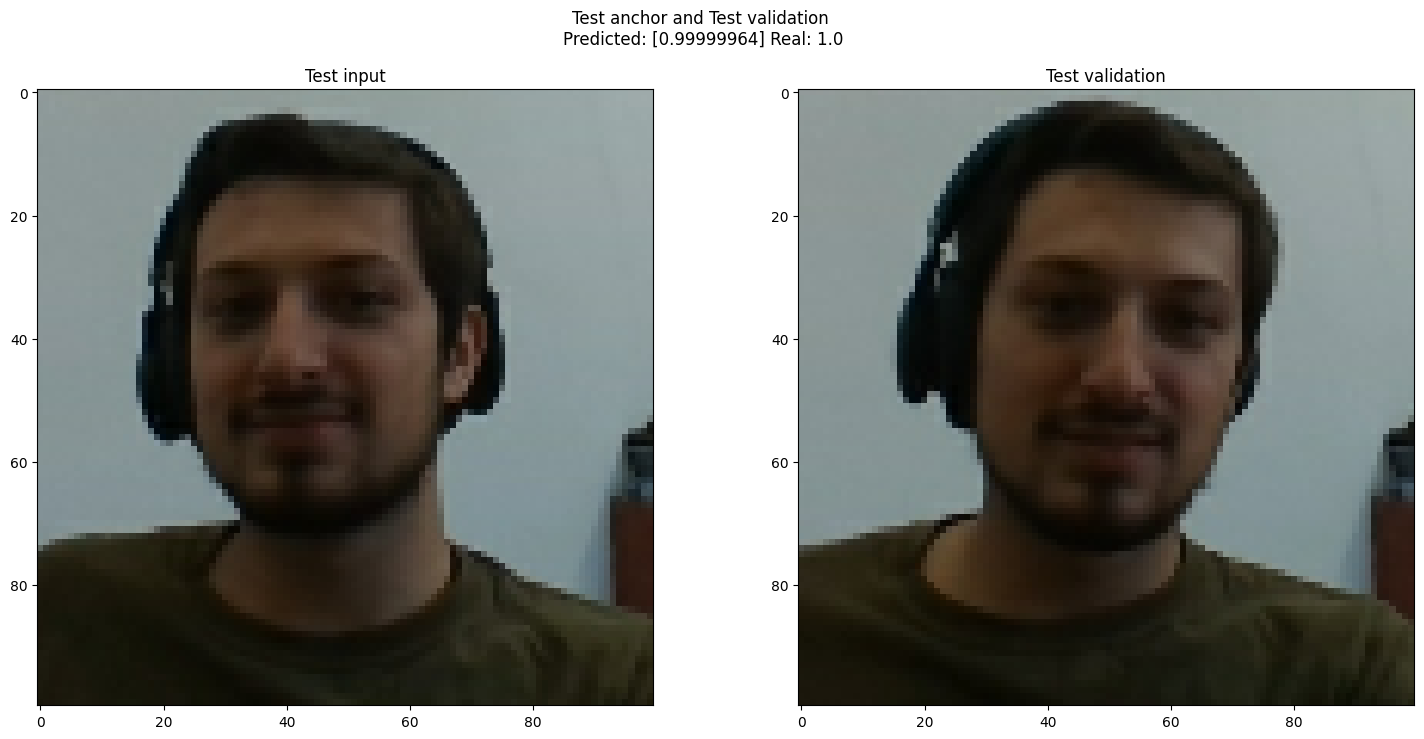

In [54]:
TEST_SAMPLE_INDEX: Final[int] = 1

plt.figure(figsize=(10, 8))
fig.suptitle(f'Test anchor and Test validation \nPredicted: {y_hat[TEST_SAMPLE_INDEX]} Real: {y_true[TEST_SAMPLE_INDEX]}')

ax1.imshow(test_input[TEST_SAMPLE_INDEX]) # Index of test sample
ax1.set_title('Test input')
ax2.imshow(test_val[TEST_SAMPLE_INDEX]) # Index of test sample
ax2.set_title('Test validation')
plt.show()

## Saving the model

In [59]:
WEIGHTS_FILENAME: Final[str] = 'siamesemodel.h5'

In [57]:
# Save the weights
siamese_model.save(path.join(OUTPUTS_PATH, WEIGHTS_FILENAME))

In [58]:
# Model reload from file
model = tf.keras.models.load_model(
    WEIGHTS_FILENAME, 
    
    # Adding the custom layers we created on our own
    custom_objects={
        'L1Dist': L1Dist, # Custom layer that need to be loaded
        'BinaryCrossentropy': tf.losses.BinaryCrossentropy
    }
)

#### Working with weights only

The `load_weights()` function can be used to load the weights also. <br />
The `save_weights()` function saves only the weights, the `save()` function saves optimizer state as well.

## Real time test